<a href="https://colab.research.google.com/github/CPeti/Spot-price-prediction/blob/peter-dev/exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
# import data from csv
data = pd.read_csv('./data/data_NO2.csv', sep=';')
data.head()

,datetime_utc,volume_demand,volume_production,spot_price
0,2015-12-31 23:00:00+00:00,4043.0,7818.0,16.39
1,2016-01-01 00:00:00+00:00,4010.0,7694.0,16.04
2,2016-01-01 01:00:00+00:00,3930.0,7437.0,15.74
3,2016-01-01 02:00:00+00:00,3839.0,7120.0,15.57
4,2016-01-01 03:00:00+00:00,3833.0,7041.0,15.47


In [14]:
# count the number of missing values in each column
missing_values = data.isnull().sum()
missing_values

datetime_utc         0
volume_demand        0
volume_production    0
spot_price           0
dtype: int64

In [15]:
# add calendar features
data['date'] = pd.to_datetime(data['datetime_utc'])
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['hour'] = data['date'].dt.hour
data['dayofweek'] = data['date'].dt.dayofweek

In [16]:
# additional time features
data['weekend'] = data['dayofweek'].apply(lambda x: 1 if x > 4 else 0)
data['working_hours'] = data['hour'].apply(lambda x: 1 if 8 <= x <= 17 else 0)
data['night'] = data['hour'].apply(lambda x: 1 if 0 <= x <= 6 else 0)
data['morning'] = data['hour'].apply(lambda x: 1 if 7 <= x <= 11 else 0)
data['afternoon'] = data['hour'].apply(lambda x: 1 if 12 <= x <= 16 else 0)
data['evening'] = data['hour'].apply(lambda x: 1 if 17 <= x <= 23 else 0)


In [17]:
# production and demand features
data['delta'] = data['volume_production'] - data['volume_demand']

# create a feature where we sum the previous days production values
data['volume_production_rolling'] = data['volume_production'].rolling(window=48).sum()
data['volume_demand_rolling'] = data['volume_demand'].rolling(window=48).sum()




In [18]:
# shift spot_price by 24 hours as target
data['target'] = data['spot_price'].shift(-24)

In [19]:
# check correlation between features and target
# drop datetime_utc
data_ = data.drop(columns=['datetime_utc', 'date'])
correlation = data_.corr()
correlation['target'].sort_values(ascending=False)

target                       1.000000
spot_price                   0.917910
year                         0.666659
volume_production            0.101399
volume_demand                0.099505
working_hours                0.094767
delta                        0.087912
month                        0.081791
morning                      0.079679
hour                         0.046832
afternoon                    0.039247
volume_demand_rolling        0.031718
volume_production_rolling   -0.002349
evening                     -0.006977
day                         -0.007680
weekend                     -0.041984
dayofweek                   -0.054476
night                       -0.099276
Name: target, dtype: float64

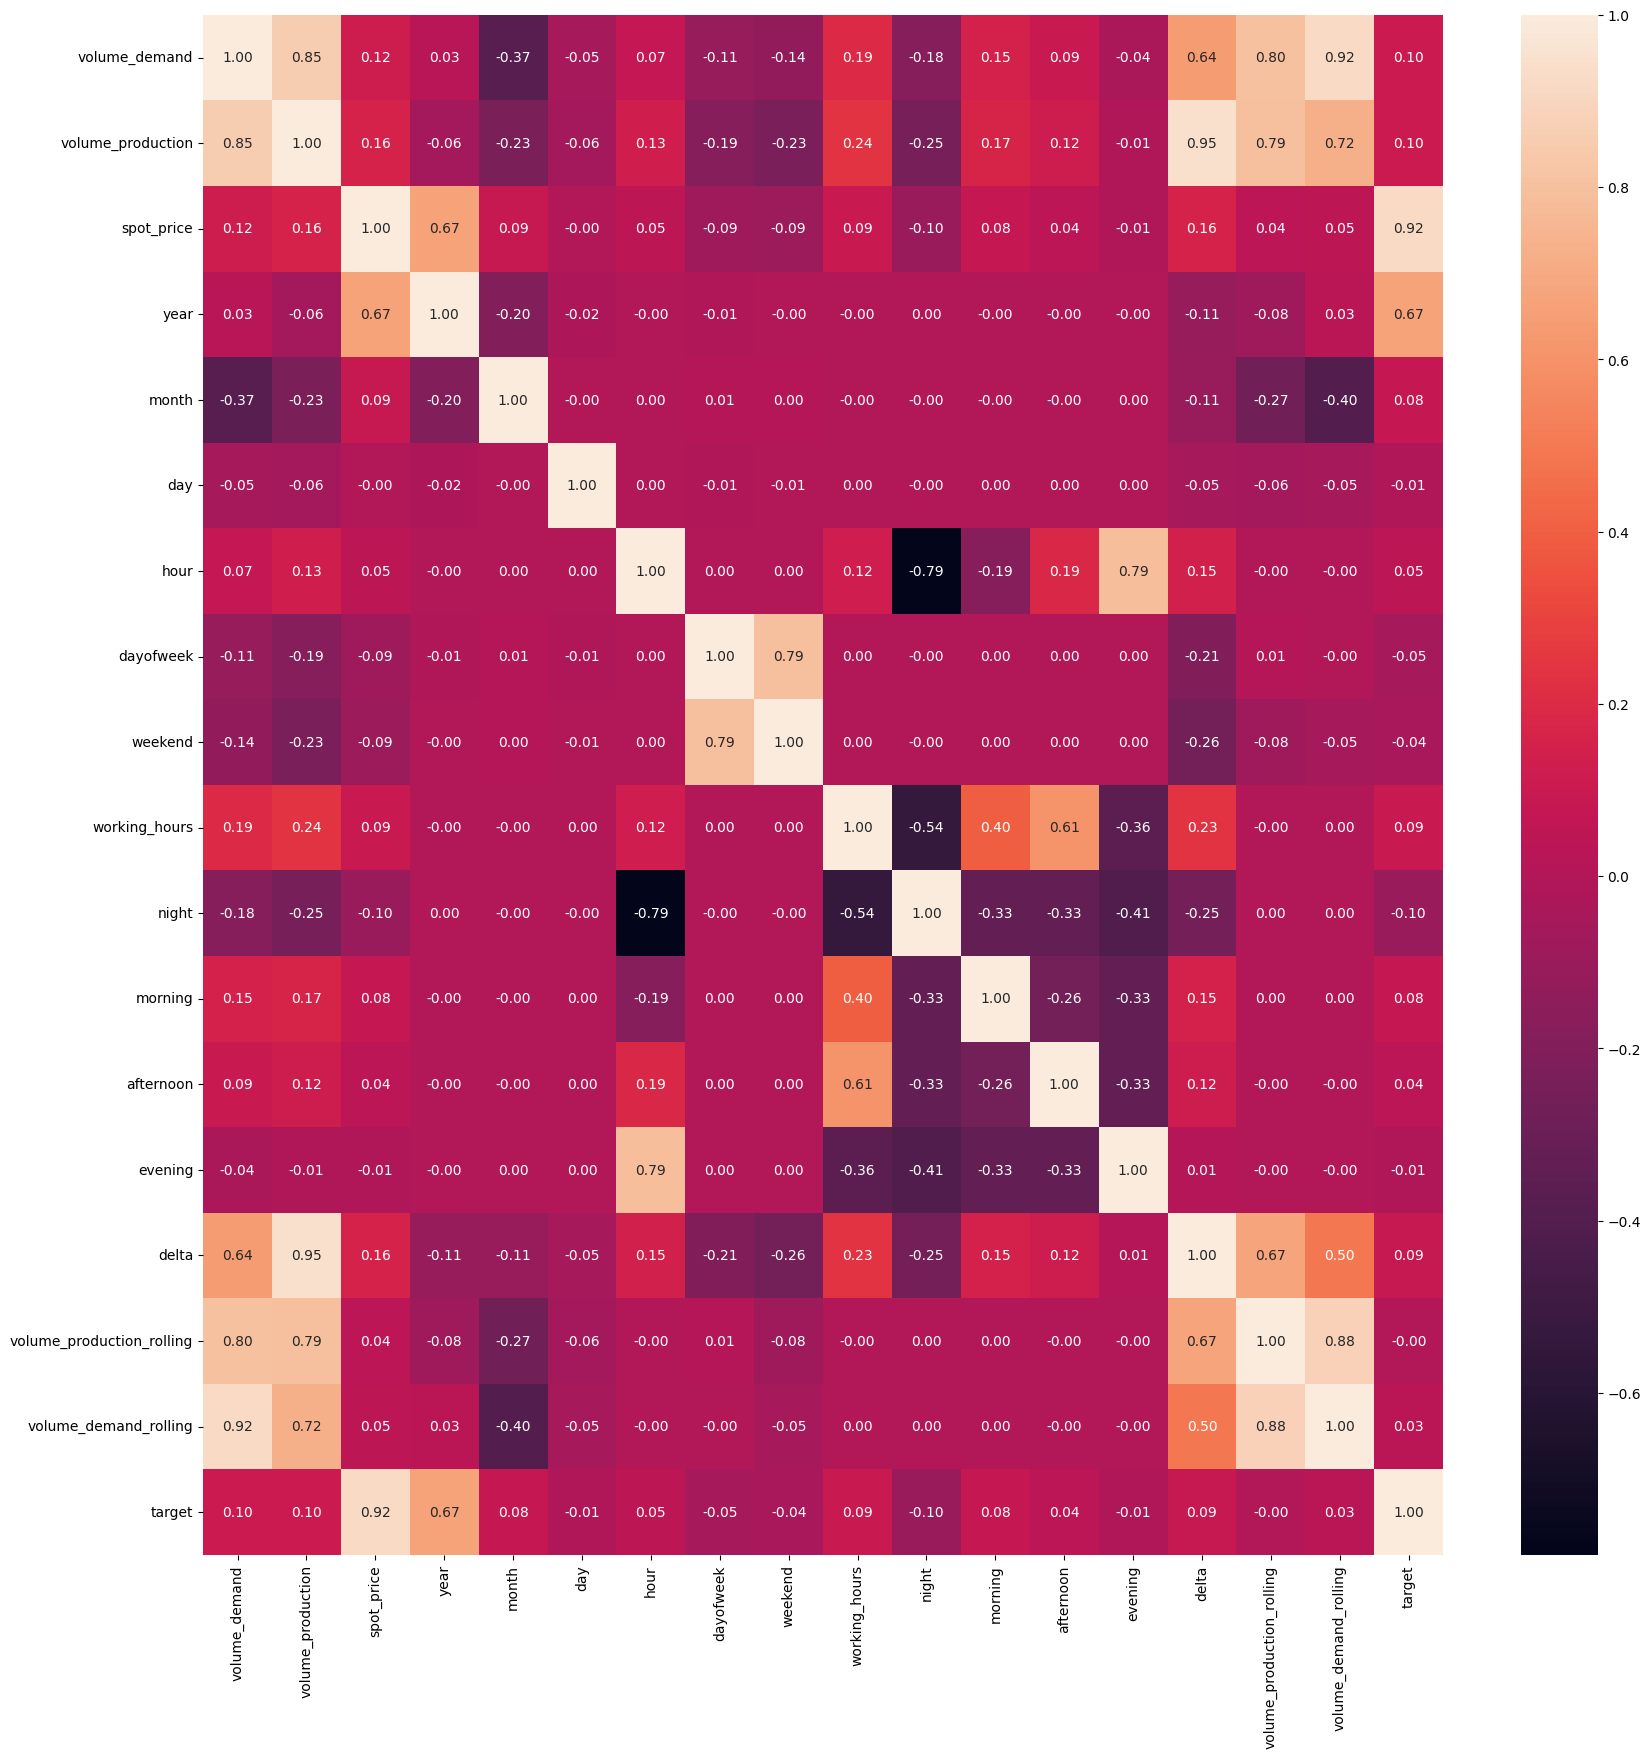

In [20]:
# correlation heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(correlation, annot=True, fmt=".2f")
plt.show()


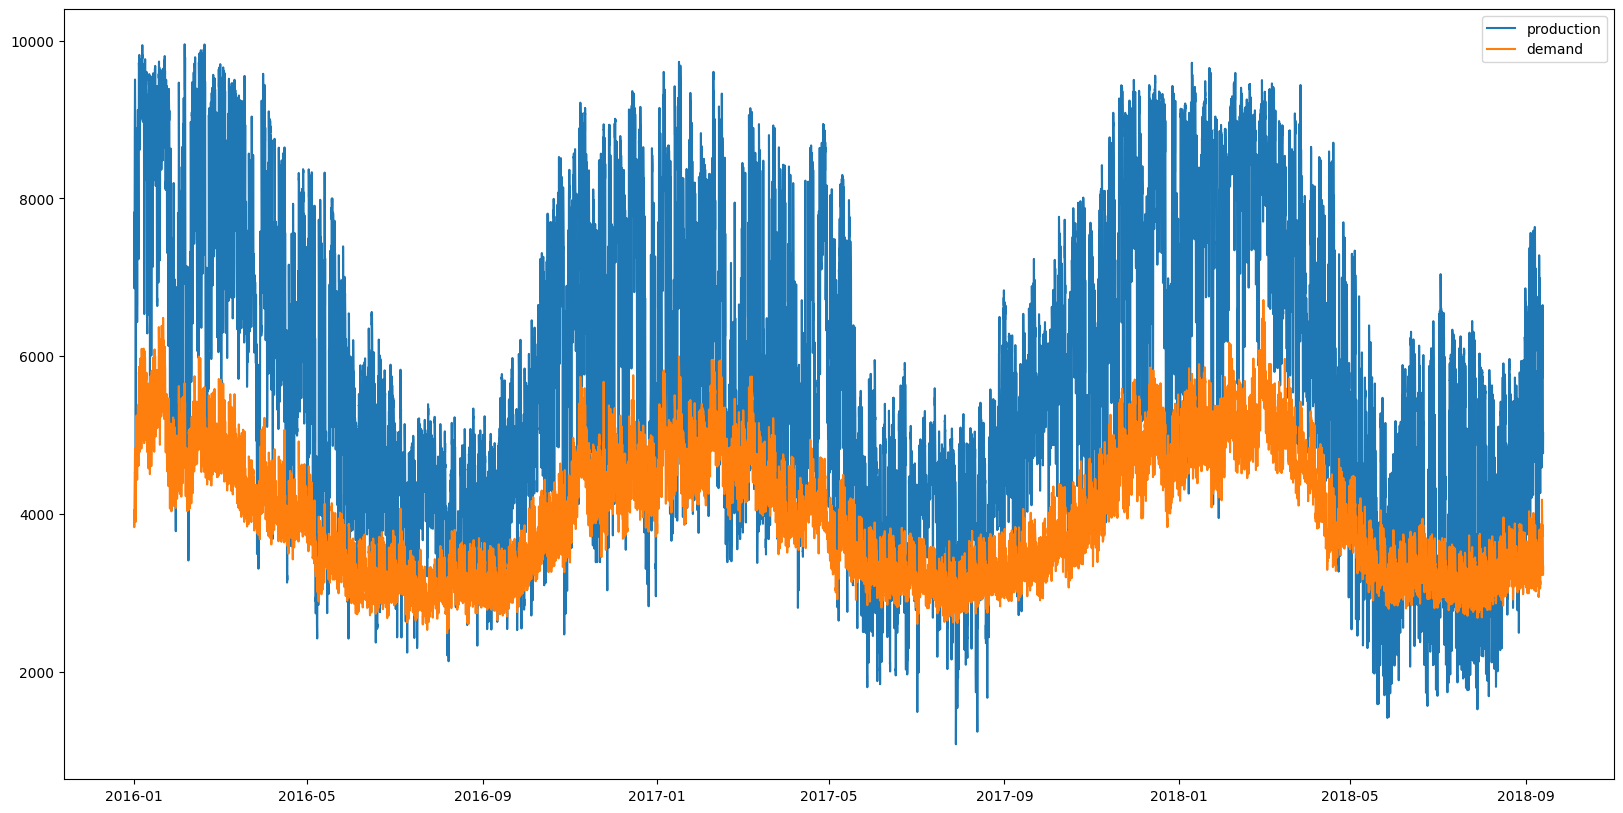

In [21]:
# plot production and demand
plt.figure(figsize=(20, 10))
plt.plot(data['date'], data['volume_production'], label='production')
plt.plot(data['date'], data['volume_demand'], label='demand')
plt.legend()

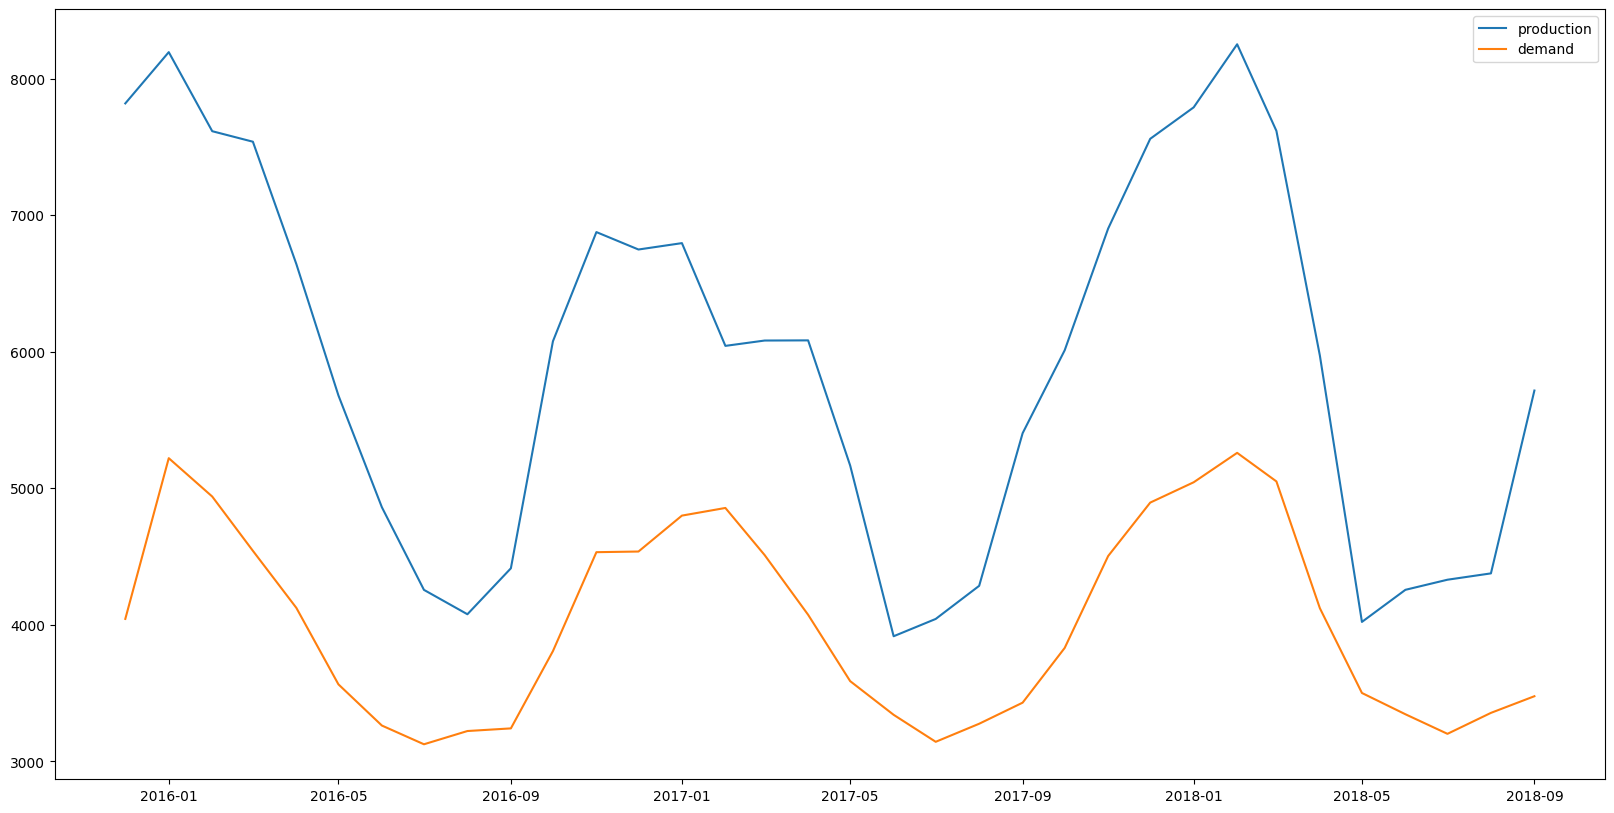

In [22]:
# calculate production and demand monthly averages
monthly = data.groupby(['year', 'month']).agg({'volume_production': 'mean', 'volume_demand': 'mean'}).reset_index()
monthly['date'] = pd.to_datetime(monthly[['year', 'month']].assign(day=1))
# plot production and demand monthly
plt.figure(figsize=(20, 10))
plt.plot(monthly['date'], monthly['volume_production'], label='production')
plt.plot(monthly['date'], monthly['volume_demand'], label='demand')
plt.legend()


